In [1]:
import numpy as np
import pointCollection as pc
import matplotlib.pyplot as plt
from make_sim_along_track import make_sim_tracks, apply_errors, apply_shifts, z_DEM
%load_ext autoreload
%autoreload 2
%matplotlib inline
from LSsurf.smooth_fit import smooth_fit


# generate the error-free data

In [2]:
# make tracks, shift by RGT pointing error
# this is a location on the east-central coast of Greenland.  We'll generate ATL06-type data, 
# one measurement every 20 m.  The default data width is 50 km, which is more than enough 

xy0 = [-160000, -2170000]
D=make_sim_tracks(EPSG=3413, x_0=xy0[0], y_0=xy0[1], product='ATL06',
                  t_unit='year', cycles=np.arange(1, 20))

# apply_shifts simulates ICESat-2's inaccuracy in pointing to the RGTs.  This shift is reported
# accurately in the data.

apply_shifts(
    D,
    ['rgt','cycle'], 10, update_yatc=True);


# Simple case: planar surface

For this demo we will generate data sampled from a plane with a 10% slope.  No height-change signal will be applied, so the only height changes will be due to biases and errors in the data.

We will solve once for z0 and dh/dt without taking into account biases in the data, and again taking biases into account.

In [3]:

# define a function to calculate elevations

def z_plane(D, mean_slope=0.1, xy0=[0,0] ):
    return (D.x-xy0[0])*mean_slope
z_fn = z_plane
z_args = {'mean_slope':0.1, 'xy0':xy0}

# Apply_errors uses the surface topography function and the uncertainty 
# in geolocation knowledge to assign vertical errors to the data.  It also
# applies random errors associated with meausrement noise and assigns the
# error estimates 

sigma={'geoloc':3.5,'r':0.03,'z_corr':0.03,'z_uncorr':0.15/np.sqrt(57)}
data=apply_errors(D, z_fn = z_plane, z_args=z_args, sigma=sigma)

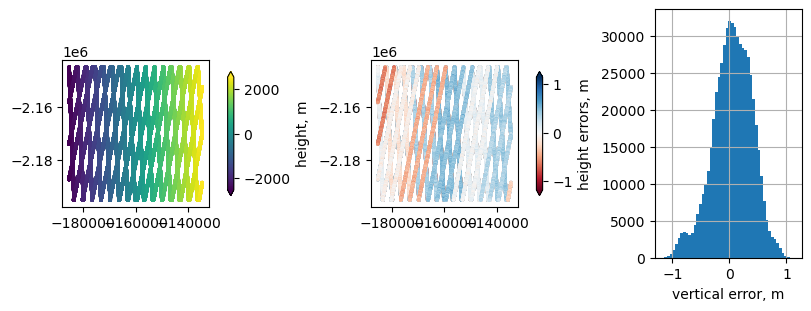

In [4]:
hf, hax = plt.subplots(1, 3, figsize=[8, 3], layout='constrained')

plt.sca(hax[0])
plt.colorbar(
    plt.scatter(data.x[::5], data.y[::5],2, 
                c=data.z[::5]), label='height, m',
                shrink=0.5, extend='both')

plt.sca(hax[1])
plt.colorbar(
    plt.scatter(data.x[::5], data.y[::5],2, 
                c=data.z[::5] - z_plane(data[::5], **z_args), cmap='RdBu'), label='height errors, m',
                shrink=0.5, extend='both')

plt.sca(hax[2])
plt.hist(data.z[::5] - z_plane(data[::5], **z_args), 50);
plt.gca().set_xlabel('vertical error, m')
for ax in hax[0:2]:
    ax.set_aspect(1)
plt.gca().grid(True)

### solve for an ATL15-type height / height-change solution:

In [5]:

# ATL14 parameters
E_d3zdx2dt=0.0001
E_d2z0dx2=0.06
E_d2zdt2=50000

cycle_range=[np.min(data.cycle), np.max(data.cycle)]
bias_params=None
data.assign({'sigma':np.zeros_like(data.z)+0.1})

data_nobias=data.copy()

ctr={'x':xy0[0],'y':xy0[1],'t':np.round(np.mean(cycle_range))*0.25}
W={'x':3.e4,'y':3.e4,'t':np.diff(cycle_range)*0.25}
spacing={'z0':100, 'dz':500, 'dt':0.25}

data_gap_scale=2500
E_RMS={'d2z0_dx2':E_d2z0dx2, 'dz0_dx':E_d2z0dx2*data_gap_scale, 'd3z_dx2dt':E_d3zdx2dt, 'd2z_dxdt':E_d3zdx2dt*data_gap_scale,  'd2z_dt2':E_d2zdt2}

# run the fit with no bias params
S_nobias=smooth_fit(data=data_nobias[::5], 
                    ctr=ctr, 
                    W=W, 
                    spacing=spacing, 
                    E_RMS=E_RMS,
                    reference_epoch=5, compute_E=False,
                    max_iterations=1,
                    bias_params=None,
                    VERBOSE=True, 
                    dzdt_lags=[1])

bias_params=['cycle','rgt']
data.assign({'sigma_corr':np.zeros_like(data.z)+((z_args['mean_slope']*sigma['geoloc'])**2+0.03**2)**0.5})

# run the fit with bias params
S_bias=smooth_fit(data=data[::5], 
                  ctr=ctr, 
                  W=W, 
                  spacing=spacing, 
                  E_RMS=E_RMS,
                  reference_epoch=5, 
                  compute_E=False,
                  max_iterations=1,
                  bias_params=bias_params,
                  VERBOSE=True, 
                  dzdt_lags=[1])


smooth_fit: E_RMS={'d2z0_dx2': 0.06, 'dz0_dx': 150.0, 'd3z_dx2dt': 0.0001, 'd2z_dxdt': 0.25, 'd2z_dt2': 50000}
initial: 200363:
starting qr solve for iteration 0 at Thu Mar 27 16:10:52 2025
smooth_fit: E_RMS={'d2z0_dx2': 0.06, 'dz0_dx': 150.0, 'd3z_dx2dt': 0.0001, 'd2z_dxdt': 0.25, 'd2z_dt2': 50000}
initial: 200363:
starting qr solve for iteration 0 at Thu Mar 27 16:11:49 2025


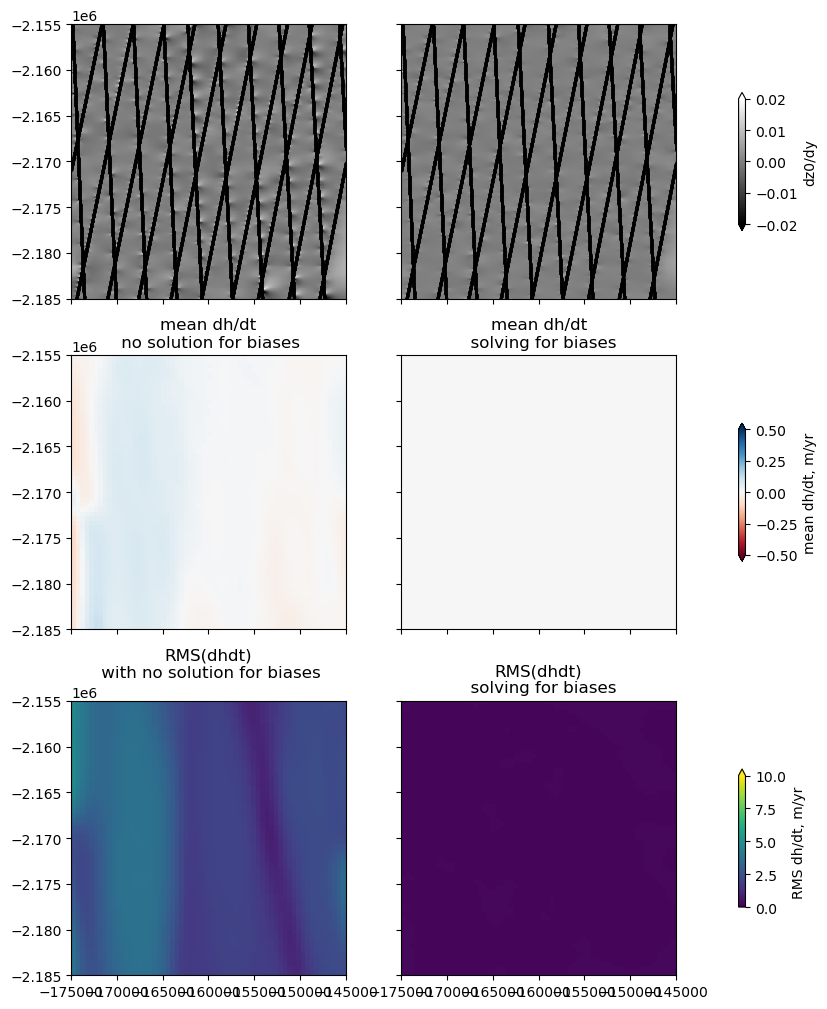

In [6]:

hf, hax=plt.subplots(3, 2, sharex=True, sharey=True, layout='constrained', figsize=[8, 10])

row=0
hi=S_nobias['m']['z0'].show(gradient=True, field='z0', clim=[-0.02, 0.02], ax=hax[row,0])
S_bias['m']['z0'].show(gradient=True, field='z0', clim=[-0.02, 0.02], ax=hax[row,1])
hb=plt.colorbar(hi, ax=hax[row,:], label='dz0/dy', shrink=0.5, extend='both')

Dsub= data.cropped(S_nobias['m']['z0'].bounds())
Dsub=Dsub[(Dsub.cycle==1)]
for ax in hax[0,:]:
    ax.plot(Dsub.x, Dsub.y,'k.', markersize=0.5)

row=1
hi=hax[row,0].imshow(np.mean(np.diff(S_nobias['m']['dz'].dz, axis=2), axis=2), clim=[-0.5, 0.5], cmap='RdBu', extent=S_nobias['m']['dz'].extent)
hax[row,0].set_title('mean dh/dt\n no solution for biases')
hax[row,1].imshow(np.mean(np.diff(S_bias['m']['dz'].dz, axis=2), axis=2), clim=[-0.5, 0.5], cmap='RdBu', extent=S_nobias['m']['dz'].extent)
hax[row,1].set_title('mean dh/dt\n  solving for biases')
hb=plt.colorbar(hi, ax=hax[row,:], label='mean dh/dt, m/yr', shrink=0.5, extend='both')

row=2
hi=hax[row,0].imshow(np.std(np.diff(S_nobias['m']['dz'].dz, axis=2), axis=2)*4, clim=[0, 10], extent=S_nobias['m']['dz'].extent)
hax[row,0].set_title('RMS(dhdt)\n with no solution for biases')
hax[row,1].imshow(np.std(np.diff(S_bias['m']['dz'].dz, axis=2), axis=2)*4, clim=[0, 10], extent=S_nobias['m']['dz'].extent)
hax[row,1].set_title('RMS(dhdt)\n  solving for biases')
hb=plt.colorbar(hi, ax=hax[row,:], label='RMS dh/dt, m/yr', shrink=0.5, extend='max')

for ax in hax.ravel():
    ax.set_aspect(1)

# Greenland DEM demo

In these demos, we'll use a DEM from Greenland to define the surface topography

## DEM only no height change

Version 1: no height-change in the data, so all signal comes from errors

The z_DEM function extracts topography data from a DEM file (here some arcticDEM tiles, see the get_data.sh script in the repo root directory).

In [7]:

sigma={'geoloc':3.5,
        'r':0.03,
        'fp_per_seg':57,
        'fp':5.5,
        'pulse_z':0.68*0.15}

z_DEM_args={'DEM_file':'../data/ArcticDEM.vrt', 
                        'W':3.5e4,
                        'xy0' : xy0}
z0, DEM= z=z_DEM(D, return_DEM=True, **z_DEM_args)
z_args['DEM']=DEM
D.assign(z=z0)
data=apply_errors(D, z_fn=z_DEM, z_args=z_DEM_args, sigma=sigma)

In [8]:

# ATL14 parameters
E_d3zdx2dt=0.0001
E_d2z0dx2=0.06
E_d2zdt2=50000

cycle_range=[np.min(data.cycle), np.max(data.cycle)]
bias_params=None

ctr={'x':xy0[0],'y':xy0[1],'t':np.round(np.mean(cycle_range)*0.25)}
W={'x':3.e4,'y':3.e4,'t':np.diff(cycle_range)*0.25}
spacing={'z0':100, 'dz':500, 'dt':0.25}

data.crop([ctr['x']+np.array([-1/2, 1/2])*W['x'],
           ctr['y']+np.array([-1/2, 1/2])*W['y']])

bias_params=['cycle','rgt']
_, crp_dict=pc.unique_by_rows(np.c_[data.cycle, data.rgt, data.pair], return_dict=True)

# calculate sigma_corr based on the median slope for each cycle/row/pair
data.assign(sigma_corr = np.zeros_like(data.z)+0.03)
for crp, jj in crp_dict.items():
    data.sigma_corr[jj] = np.sqrt((np.median(data.slope_mag[jj])*sigma['geoloc'])**2 + sigma['r']**2)

#data.assign({'sigma_corr':np.zeros_like(data.z)+((z_args['mean_slope']*sigma['geoloc'])**2+0.03**2)**0.5})

data_gap_scale=2500
E_RMS={'d2z0_dx2':E_d2z0dx2, 'dz0_dx':E_d2z0dx2*data_gap_scale, 'd3z_dx2dt':E_d3zdx2dt, 'd2z_dxdt':E_d3zdx2dt*data_gap_scale,  'd2z_dt2':E_d2zdt2}

# run the fit with bias params
S_fit=smooth_fit(data=data[::5], ctr=ctr, W=W, spacing=spacing, E_RMS=E_RMS,
             reference_epoch=5, compute_E=False,
             max_iterations=1,
             bias_params=bias_params,
             VERBOSE=True, dzdt_lags=[1])
m_fit=S_fit['m']

smooth_fit: E_RMS={'d2z0_dx2': 0.06, 'dz0_dx': 150.0, 'd3z_dx2dt': 0.0001, 'd2z_dxdt': 0.25, 'd2z_dt2': 50000}
initial: 189191:
starting qr solve for iteration 0 at Thu Mar 27 16:12:59 2025


In [9]:
xg, yg = np.meshgrid(m_fit['z0'].x, m_fit['z0'].y)

m_data = {'z0':m_fit['z0'].copy().assign(z0=z_DEM([xg, yg], **z_DEM_args)),
          'dz':m_fit['dz'].copy().assign(dz=np.zeros_like(m_fit['dz'].dz))}


Text(0, 0.5, 'mean δz (m)')

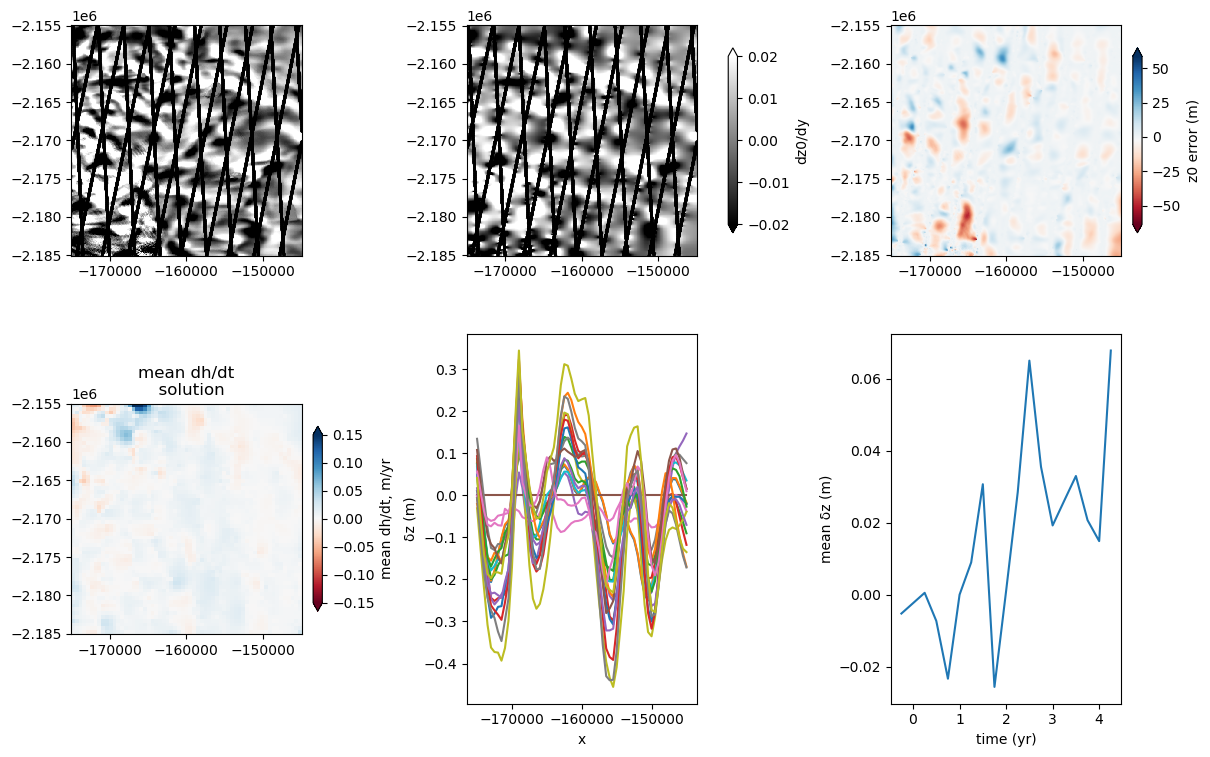

In [10]:
hf, hax=plt.subplots(2, 3,  layout='constrained', figsize=[12,8])

row=0
hi=m_data['z0'].show(gradient=True, field='z0', clim=[-0.02, 0.02], ax=hax[row,0])
m_fit['z0'].show(gradient=True, field='z0', clim=[-0.02, 0.02], ax=hax[row,1])
hb=plt.colorbar(hi, ax=hax[row,0:2], label='dz0/dy', shrink=0.5, extend='both')

Dsub= data.cropped(m_data['z0'].bounds())
Dsub=Dsub[(Dsub.cycle==1)]
for ax in hax[0,0:2]:
    ax.plot(Dsub.x, Dsub.y,'k.', markersize=0.5)

hi=hax[0, 2].imshow(m_fit['z0'].z0 - m_data['z0'].z0, extent=m_data['z0'].img_extent, origin='lower', cmap='RdBu')
plt.colorbar(hi, ax=hax[0,2], label='z0 error (m)', shrink=0.5, extend='both')


shp = m_fit['dz'].shape
row=1
hi=hax[row,0].imshow(np.mean(np.diff(m_fit['dz'].dz, axis=2), axis=2), clim=[-0.15, 0.15], cmap='RdBu', extent=m_data['dz'].extent)
hax[row,0].set_title('mean dh/dt\n  solution')
hb=plt.colorbar(hi, ax=hax[row,0], label='mean dh/dt, m/yr', shrink=0.5, extend='both')

hax[row, 1].plot(m_fit['dz'].x, m_fit['dz'].dz[:, int(shp[1]/2),:])
hax[row, 1].set_xlabel('x')
hax[row, 1].set_ylabel('δz (m)')

dzbar = np.mean(np.mean(m_fit['dz'].dz, axis=0), axis=0)
hax[row, 2].plot(m_fit['dz'].t, dzbar)
hax[row, 2].set_xlabel('time (yr)')
hax[row, 2].set_ylabel('mean δz (m)')




## Include low-elevation time series

In this version we'll introduce an height-change signal derived from a SMB model in Greenland


In [11]:
def SMB_t_interp(D, t0, z0):
    return np.interp(D.t, t0, z0)
    

In [13]:
ctr={'x':xy0[0],'y':xy0[1],'t':2.5}
W={'x':3.e4,'y':3.e4,'t':4}

sigma={'geoloc':3.5,
        'r':0.03,
        'fp_per_seg':57,
        'fp':5.5,
        'pulse_z':0.68*0.15}

SMB=pc.data().from_h5('coastal_SMB_time_series.h5')
SMB.t -= np.min(SMB.t)
SMB.z -= np.interp(ctr['t'], SMB.t, SMB.z)
dz_of_t = {'function': SMB_t_interp, 
           'args':{'t0':SMB.t,'z0':SMB.z}}

z_DEM_SMB_args={'DEM_file':'../data/ArcticDEM.vrt', 
                        'W':3.5e4,
                        'xy0' : xy0, 
                        'dz_of_t': dz_of_t}
z0, DEM = z_DEM(D, return_DEM=True, **z_DEM_SMB_args)
z_DEM_SMB_args['DEM']=DEM
D.assign(z=z0)

data=apply_errors(D, z_fn=z_DEM, z_args=z_DEM_SMB_args, sigma=sigma)

Text(0, 0.5, 'data - DEM (m)')

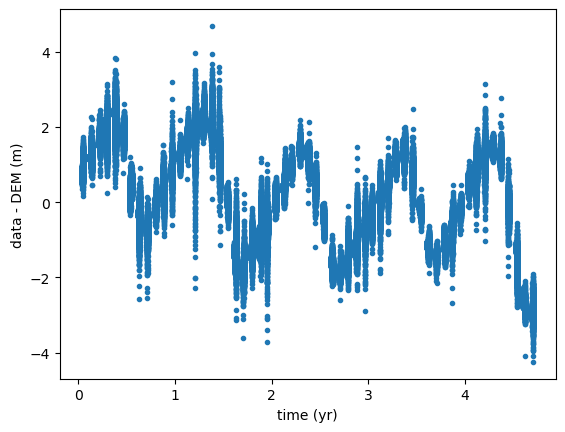

In [14]:
plt.figure()
#z0 = z_DEM(D.cropped([ctr['x']+np.array([-1/2, 1/2])*W['x'],
#           ctr['y']+np.array([-1/2, 1/2])*W['y']]),  **z_fn_args_noT)
plt.plot(data.t, data.z-data.DEM_h + dz_of_t['function'](data, **dz_of_t['args']),'.')
plt.gca().set_xlabel('time (yr)')
plt.gca().set_ylabel('data - DEM (m)')

In [15]:
# ATL14 parameters
E_d3zdx2dt=0.0001
E_d2z0dx2=0.06
E_d2zdt2=50000

cycle_range=[np.min(data.cycle), np.max(data.cycle)]
bias_params=None
data.assign({'sigma':np.zeros_like(data.z)+0.1})

ctr={'x':xy0[0],'y':xy0[1],'t':np.ceil(np.mean(cycle_range))*0.25}
W={'x':3.e4,'y':3.e4,'t':np.diff(cycle_range)*0.25}
spacing={'z0':100, 'dz':1000, 'dt':0.25}

data.crop([ctr['x']+np.array([-1/2, 1/2])*W['x'],
           ctr['y']+np.array([-1/2, 1/2])*W['y']])

bias_params=['cycle','rgt']
_, crp_dict=pc.unique_by_rows(np.c_[data.cycle, data.rgt, data.pair], return_dict=True)
data.assign(sigma_corr = np.zeros_like(data.z)+0.03)
for crp, jj in crp_dict.items():
    data.sigma_corr[jj] = np.sqrt((np.median(data.slope_mag[jj])*sigma['geoloc'])**2 + sigma['r']**2)

data_gap_scale=2500
E_RMS={'d2z0_dx2':E_d2z0dx2, 'dz0_dx':E_d2z0dx2*data_gap_scale, 'd3z_dx2dt':E_d3zdx2dt, 'd2z_dxdt':E_d3zdx2dt*data_gap_scale,  'd2z_dt2':E_d2zdt2}
# run the fit with bias params
S_fit=smooth_fit(data=data[::5], ctr=ctr, W=W, spacing=spacing, E_RMS=E_RMS,
             reference_epoch=5, compute_E=False,
             max_iterations=1,
             bias_params=bias_params,
             VERBOSE=True, dzdt_lags=[1])
m_fit=S_fit['m']

smooth_fit: E_RMS={'d2z0_dx2': 0.06, 'dz0_dx': 150.0, 'd3z_dx2dt': 0.0001, 'd2z_dxdt': 0.25, 'd2z_dt2': 50000}
initial: 200304:
starting qr solve for iteration 0 at Thu Mar 27 16:28:05 2025


(0.040014942962097025, 4.703431156402233)

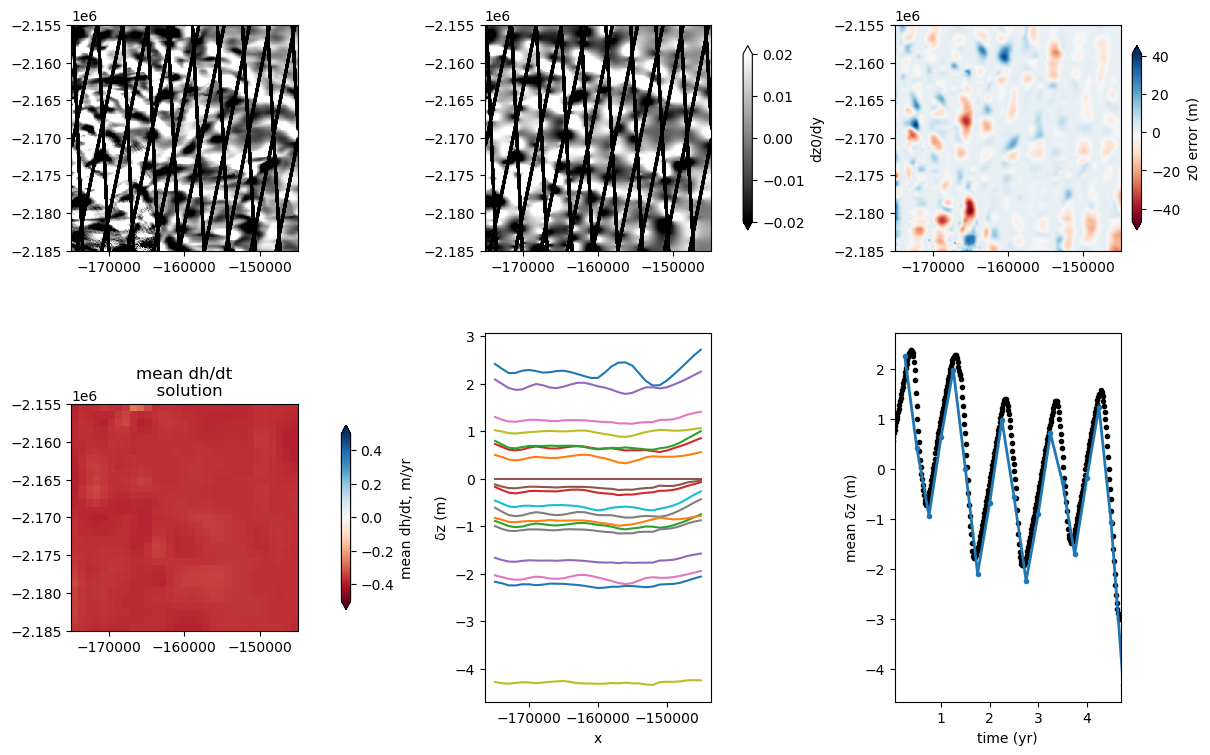

In [16]:
hf, hax=plt.subplots(2, 3,  layout='constrained', figsize=[12,8])

row=0
hi=m_data['z0'].show(gradient=True, field='z0', clim=[-0.02, 0.02], ax=hax[row,0])
m_fit['z0'].show(gradient=True, field='z0', clim=[-0.02, 0.02], ax=hax[row,1])
hb=plt.colorbar(hi, ax=hax[row,0:2], label='dz0/dy', shrink=0.5, extend='both')

Dsub= data.cropped(m_data['z0'].bounds())
Dsub=Dsub[(Dsub.cycle==1)]
for ax in hax[0,0:2]:
    ax.plot(Dsub.x, Dsub.y,'k.', markersize=0.5)

hi=hax[0, 2].imshow(m_fit['z0'].z0 - m_data['z0'].z0, extent=m_data['z0'].img_extent, origin='lower', cmap='RdBu')
plt.colorbar(hi, ax=hax[0,2], label='z0 error (m)', shrink=0.5, extend='both')


shp = m_fit['dz'].shape
row=1
hi=hax[row,0].imshow(np.mean(np.diff(m_fit['dz'].dz, axis=2), axis=2), clim=[-0.5, 0.5], cmap='RdBu', extent=m_data['dz'].extent)
hax[row,0].set_title('mean dh/dt\n  solution')

hb=plt.colorbar(hi, ax=hax[row,0], label='mean dh/dt, m/yr', shrink=0.5, extend='both')

hax[row, 1].plot(m_fit['dz'].x, m_fit['dz'].dz[:, int(shp[1]/2),:])
hax[row, 1].set_xlabel('x')
hax[row, 1].set_ylabel('δz (m)')

dzbar = np.mean(np.mean(m_fit['dz'].dz, axis=0), axis=0)
hax[row, 2].plot(SMB.t,SMB.z,'k.', label='input δz')
hax[row, 2].plot(m_fit['dz'].t, dzbar, linewidth=2, marker='.')
hax[row, 2].set_xlabel('time (yr)')
hax[row, 2].set_ylabel('mean δz (m)')
hax[row, 2].set_xlim([np.min(data.t), np.max(data.t)])



#### Notes:
* There are significant errors in the recovered DEM, but only in the gaps beteween the tracks where the model is not informed by data. 

* The height-change solution is very close to the input data, with some overshoot and undershoot determined by the timing of the nodes and the measurments.

## test seasonal-signal recovery by shifting t0 by 0, 1, and 2 months

To try to improve the resolution of the seasonal cycle, conduct the 3-mo-resolution inversion with the zero-time node shifted by 1/12 year and 2/12 yr.

In [17]:
dz_fit_monthly = {}
for delta_month in [0, 1, 2]:
    ctr['t'] = 2.5 + delta_month/12
    S_fit=smooth_fit(data=data[::5], ctr=ctr, W=W, spacing=spacing, E_RMS=E_RMS,
             reference_epoch=5, compute_E=False,
             max_iterations=1,
             bias_params=bias_params,
             VERBOSE=True, dzdt_lags=[1])
    dz_fit_monthly[delta_month]=S_fit['m']['dz']




smooth_fit: E_RMS={'d2z0_dx2': 0.06, 'dz0_dx': 150.0, 'd3z_dx2dt': 0.0001, 'd2z_dxdt': 0.25, 'd2z_dt2': 50000}
initial: 200304:
starting qr solve for iteration 0 at Thu Mar 27 16:40:01 2025
smooth_fit: E_RMS={'d2z0_dx2': 0.06, 'dz0_dx': 150.0, 'd3z_dx2dt': 0.0001, 'd2z_dxdt': 0.25, 'd2z_dt2': 50000}
initial: 196676:
starting qr solve for iteration 0 at Thu Mar 27 16:40:24 2025
smooth_fit: E_RMS={'d2z0_dx2': 0.06, 'dz0_dx': 150.0, 'd3z_dx2dt': 0.0001, 'd2z_dxdt': 0.25, 'd2z_dt2': 50000}
initial: 192795:
starting qr solve for iteration 0 at Thu Mar 27 16:40:46 2025


In [18]:
dzbar_of_three_monthly={}
for delta_month, dz in dz_fit_monthly.items():
    dzbar_of_three_monthly[delta_month] = {'t':dz.t,'dz':np.mean(np.mean(dz.dz, axis=0), axis=0)}


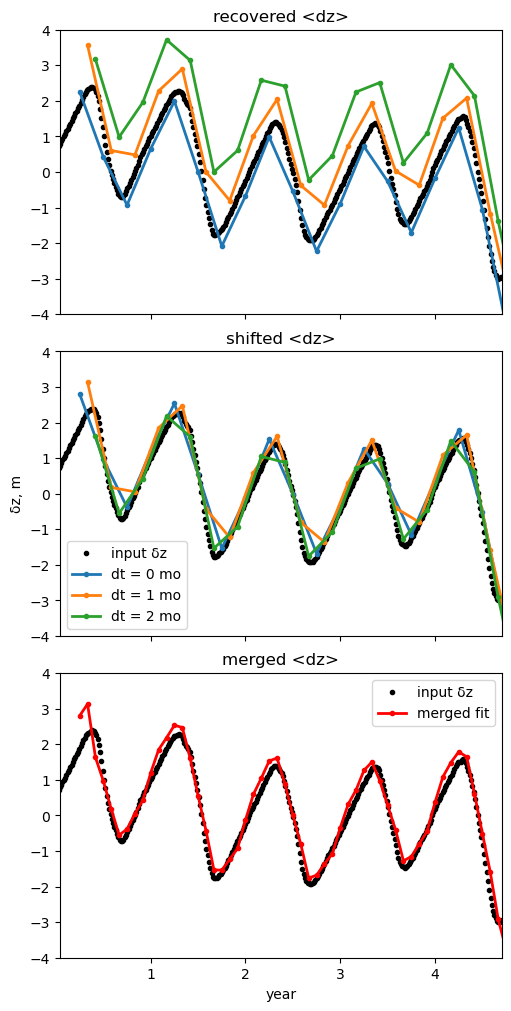

In [19]:
hf, hax=plt.subplots(3, 1, figsize=[5,10], sharex=True, layout='constrained')
for ax in hax:
    ax.plot(SMB.t,SMB.z,'k.', label='input δz')
tt=[]
zz=[]
for dt, dzbar in dzbar_of_three_monthly.items():
    hax[0].plot( dzbar['t'], dzbar['dz'], label=f'dt = {dt} mo', marker='.', linewidth=2)

    offset = np.interp(2.5, dzbar['t'], dzbar['dz'])
    hax[1].plot( dzbar['t'], dzbar['dz']-offset, label=f'dt = {dt} mo', marker='.', linewidth=2)
    tt += [dzbar['t']]
    zz += [dzbar['dz']-offset]
for ax in hax:
    ax.set_xlim([np.min(data.t), np.max(data.t)])

hax[1].legend()

hax[0].set_title('recovered <dz>')
hax[1].set_title('shifted <dz>')
hax[2].set_title('merged <dz>')
hax[2].set_xlabel('year')
hax[1].set_ylabel('δz, m')


tt=np.concatenate(tt, axis=0)
zz=np.concatenate(zz, axis=0)
ii=np.argsort(tt)
tt=tt[ii]
zz=zz[ii]
plt.sca(hax[2])
plt.plot(tt, zz,'r', linewidth=2, marker='.', label='merged fit')
plt.gca().set_xlim([np.min(data.t), np.max(data.t)])
plt.gca().legend()

for ax in hax:
    ax.set_ylim([-4, 4])

#### Notes:

By shifting the quarterly recovered models to be consistent at their time-zero nodes, we can make a combined time series that is fairly close to the input signal.  The quality of the solution suffers at the beginning and end of the time series, which should not be a surprise.

## try fitting @ 2km, 1/12 yr

By reducing the spatial resolution of the recovered signal, we should be able to recover the temporal signal at no large additional computational cost.  

In [20]:
# ATL14 parameters
E_d3zdx2dt=0.0001
E_d2z0dx2=0.06
E_d2zdt2=500000

cycle_range=[np.min(data.cycle), np.max(data.cycle)]
bias_params=None

ctr={'x':xy0[0],'y':xy0[1],'t':np.ceil(np.mean(cycle_range))*0.25}
W={'x':3.e4,'y':3.e4,'t':np.diff(cycle_range)*0.25}
# change the spacing to dz=2 km, dt = 1 mo
spacing={'z0':100, 'dz':2000, 'dt':1/12}

data.crop([ctr['x']+np.array([-1/2, 1/2])*W['x'],
           ctr['y']+np.array([-1/2, 1/2])*W['y']])

bias_params=['cycle','rgt']
_, crp_dict=pc.unique_by_rows(np.c_[data.cycle, data.rgt, data.pair], return_dict=True)
data.assign(sigma_corr = np.zeros_like(data.z)+0.03)
for crp, jj in crp_dict.items():
    data.sigma_corr[jj] = np.sqrt((np.median(data.slope_mag[jj])*sigma['geoloc'])**2 + sigma['r']**2)

#data.assign({'sigma_corr':np.zeros_like(data.z)+((z_args['mean_slope']*sigma['geoloc'])**2+0.03**2)**0.5})

data_gap_scale=2500
E_RMS={'d2z0_dx2':E_d2z0dx2, 'dz0_dx':E_d2z0dx2*data_gap_scale, 'd3z_dx2dt':E_d3zdx2dt, 'd2z_dxdt':E_d3zdx2dt*data_gap_scale,  'd2z_dt2':E_d2zdt2}
# run the fit with bias params
S_fit=smooth_fit(data=data[::5], ctr=ctr, W=W, spacing=spacing, E_RMS=E_RMS,
             reference_epoch=15, compute_E=False,
             max_iterations=1,
             bias_params=bias_params,
             VERBOSE=True, dzdt_lags=[3])
m_fit_1mo=S_fit['m']

smooth_fit: E_RMS={'d2z0_dx2': 0.06, 'dz0_dx': 150.0, 'd3z_dx2dt': 0.0001, 'd2z_dxdt': 0.25, 'd2z_dt2': 500000}
initial: 200304:
starting qr solve for iteration 0 at Thu Mar 27 16:41:08 2025


(-4.0, 4.0)

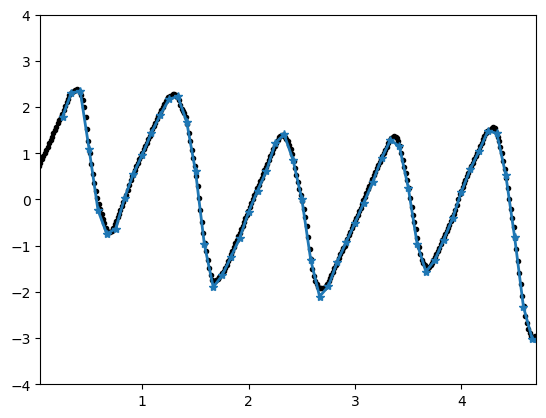

In [21]:
dzbar = np.mean(np.mean(m_fit_1mo['dz'].dz, axis=0), axis=0)
plt.figure()
#plt.plot(data.t, data.z-z0,'.')
plt.plot(SMB.t,SMB.z,'k.')

offset = np.interp(2.5, m_fit_1mo['dz'].t, dzbar)- np.interp(2.5, SMB.t, SMB.z)

plt.plot(m_fit_1mo['dz'].t, dzbar-offset, marker='*', linewidth=2)
plt.gca().set_xlim([np.min(data.t), np.max(data.t)])
plt.gca().set_ylim([-4, 4])

#### Notes:
This solution is sensitive to the expected d2z/dt2 parameter.  At E_d2zdt2=500000, the solution is very close to the input data, but at E_d2zdt2=50000 (ten times less) there is   minor undershoot at the seasonal minima and maxima.  

# code for making the SMB_of_t lookup table

In [ ]:
if False:
    SMB = pc.grid.data().from_nc('/Volumes/ice3/ben/MERRA2_hybrid/v1.2.1/gsfc_fdm_v1_2_1_gris.nc', t_range=[2015, 2023])
    
    SMB_sub=pc.data().from_dict({'t':SMB.t, 'z':SMB.h_a[114, 215,:].ravel()})
    
    SMB_sub.to_h5('coastal_SMB_time_series.h5')
    SMB=None